# Block descent on the Stochastic Block Model


Author: Roberto Ceraolo - robi.ceraolo@gmail.com

Implementation from scratch of the algorithm introuced by Ricci-Tersenghi, Javanmard, Montanari in the following paper:
https://iopscience.iop.org/article/10.1088/1742-6596/699/1/012015/pdf

Stochastic Block model created
Initial matrix created
Epoch num 0
Delta = 1.787781333628417


Q: 
0.0008


Epoch num 1
Delta = 1.8496495655769374


Q: 
0.0086


Epoch num 2
Delta = 1.8351804896390027


Q: 
0.0148


Epoch num 3
Delta = 1.8150598425560187


Q: 
0.0092


Epoch num 4
Delta = 1.7859103886575889


Q: 
0.017


Epoch num 5
Delta = 1.8048586766541457


Q: 
0.013600000000000001


Epoch num 6
Delta = 1.8144712717368923


Q: 
0.019


Epoch num 7
Delta = 1.8171556453151643


Q: 
0.029


Epoch num 8
Delta = 1.8144535085241953


Q: 
0.0026000000000000003


Epoch num 9
Delta = 1.8099390773712565


Q: 
0.013600000000000001


Epoch num 10
Delta = 1.8002902477122258


Q: 
0.007200000000000001


Epoch num 11
Delta = 1.8071896869735848


Q: 
0.013000000000000001


Epoch num 12
Delta = 1.7947882273414468


Q: 
0.0056


Epoch num 13
Delta = 1.8019336671180697


Q: 
0.012400000000000001


Epoch num 14
Delta = 1.791732919220796


Q: 
0.004


Epoch num 15
Delta = 1.7964884323982064


Q: 
0.0058

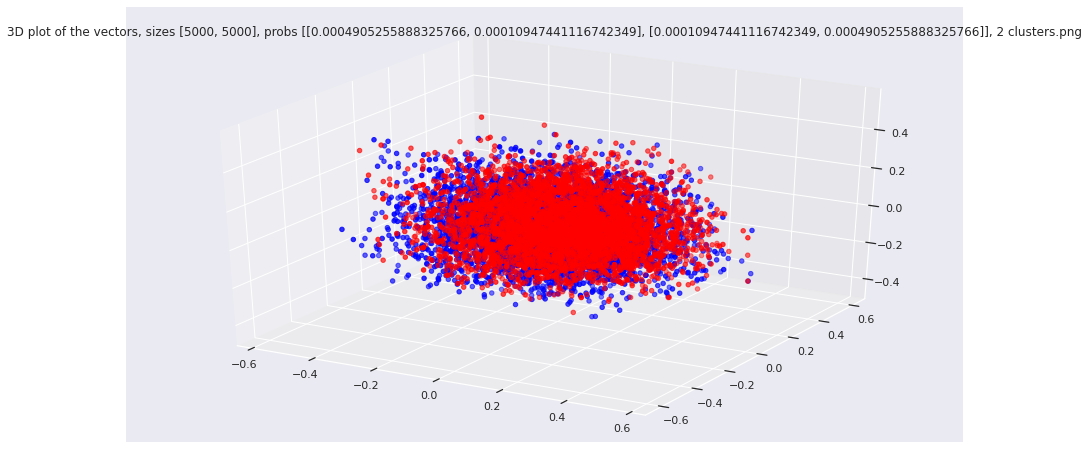

Q: 
0.3256


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 18 15:57:44 2020

@author: roberto ceraolo
"""
#from google.colab import files
import networkx as nx
import numpy as np
from sklearn.preprocessing import normalize
np.random.seed(5)
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from matplotlib import cm, colors
import seaborn as sns
from math import sqrt
from sklearn.decomposition import PCA
sns.set()

#In this settings, matrices are composed of column vectors (Xi is a column of X)

def init(m, n, seed=42):
    #n is the number of vertices
    #we need to build n arrays, 
    #with unit lenght and m components each
    np.seed = seed
    A=np.random.rand(m, n)
    A -= 0.5
    #Unit lenght contraint:
    normed_matrix = normalize(A, axis=0)
    return normed_matrix

def check(g, X):
    #This evaluates the function that must be maximized, to check that it is actually increasing
    f=0.0
    for e in g.edges:
        i, j = e
        addendum = np.dot(X[:, i], X[:, j])
        f += addendum
    return f

def update_matrix(g, X, m, n, p,q, verbose):
    Y = X.copy() #Y will be the new, updated matrix
    if p>q: 
      pos_avg = True
    else:
      pos_avg = False
    for k in range(n):
      conn_nodes = list(g.neighbors(k))
      num_conn_nodes = len(conn_nodes)

      if num_conn_nodes>0: #case in which there is at least one neighbor
        #vects_o = [X[:, a] for a in conn_nodes] #Old version
        #vects_o = np.stack(vects_o, axis=1)
        vects = X[:, [conn_nodes]] 
        vects = np.reshape(vects, (m, num_conn_nodes))
        #assert np.all(vects_o-vects<10e-3)
        if pos_avg:
          numerator = np.average(vects,axis=1) # numerator computation
        else:
          numerator = -np.average(vects,axis=1)
        Y[:, k] = numerator
        Y[:, k] /= np.linalg.norm(Y[:, k]) #Normalization
      else: #case in which node k does not have neighbors
        Y[:, k] = np.zeros(m)
    
    #Spostamento

    #norms = np.linalg.norm(Y, axis=0)
    #for i in range(n):
    #  Y[:, i] /= norms[i]
    M=np.average(Y, axis=1)
    if verbose:
      print("Global Magnetization M: ")
      print(M)
    for i in range(m):
        Y[i, :] -= M[i]
    if verbose:
      print("sum of all vectors")
      print(np.sum(Y, axis=1))
    return Y

def block_descent(g,X,p,q, max_it, verbose):
    delta_list = []
    overlap_list = []
    delta = np.inf
    eps = 10**-3
    k=0
    m, n= np.shape(X)
    
    while(delta>eps): 
      print("Epoch num " + str(k))
      k+=1
      #M = np.average(X, axis=1)#M is the Global magnetization - the vector average between all the datapoints at epoch t

      X_old = X.copy()
      #New matrix computation
      X = update_matrix(g, X, m, n, p,q,verbose)
      
      #Delta computation
      diff = X - X_old
      delta = np.max(np.linalg.norm(diff, axis = 0))
      delta_list.append(delta)
      print("Delta = " + str(delta))

      #Provisional check (which increases the running time) that the value of the function we are maximizing actually increases
      #print("f value: ")
      #print(check(g, X))
      print("\n")

      overlap_list.append(compute_overlap(X))
      print("\n")

      if k>max_it:
        break
        
    return X, k, delta_list,overlap_list
        

def initialize_graph(sizes, probs, m, n):
    g = nx.stochastic_block_model(sizes, probs, seed=0) #SBM
    #core_num = nx.core_number(g)
    #g=nx.k_core(g,2, core_num) #2-core reduction
    print("Stochastic Block model created")
    X = init(m, n) #initialization 
    print("Initial matrix created")
    return g, X


def plot_res(g, Y, sizes, probs, save=False):
    fig = plt.figure(figsize=(15,8))
    ax2 = fig.add_subplot(projection='3d')
    num_clusters = len(sizes)

    #first_clust = np.array(list(g.graph["partition"][0]))
    #second_clust = np.array(list(g.graph["partition"][1]))
    #The planted partition assigns the first n//2 nodes the cluster "0" and "1" to the second half
  
    first_clust_zeros = np.zeros(sizes[0], dtype=int)
    second_clust_ones = np.ones(sizes[1], dtype=int)
    tot_clusters = np.append(first_clust_zeros, second_clust_ones)

    title = "3D plot of the vectors, sizes {}, probs {}, {} clusters.png".format(sizes, probs, num_clusters)
    plt.title(title)
    ax2.scatter(Y[0,:],Y[1,:], Y[2,:], c=tot_clusters, cmap="bwr") #bwr #winter
    ax2.scatter(0,0,0,color="black",s=20)
    if save:
      path = "/content/drive/MyDrive/Colab Files/Stochastic Block Model/"
      path += title
      plt.savefig(path)
    plt.show()
    
    


def main(c, lambd=1, q=2, m=3, n = 10**2, ps=None, max_it=400, verbose=True):
  sizes = [n//2, n//2] #sizes of each block
  if ps is None:
    cout  = -sqrt(c)*lambd + c #getting the connections probabilities from the signal-to-noise ratio and the mean degree
    cin = q*lambd*sqrt(c) + cout 
    assert cin-cout > sqrt(c)
    p_in = cin/n
    p_out = cout/n
  else:
    p_in, p_out = ps
    cin = None
    cout = None

  probs = [[p_in, p_out], [p_out, p_in]] #probabilities of connections between blocks
   #For the time being, we assume the inside-cluster probabilities  equal for the two clusters.Moreover, we focus on the case in which cin > cout, i.e. p>q

  g, X = initialize_graph(sizes, probs, m, n) #Initialization of graph and matrix

  Y, t, delta_list, overlap_list = block_descent(g, X, p_in, p_out, max_it, verbose) #Algorithm run

  plot_res(g, Y, sizes, probs, save=False) #Plot result

  compute_overlap(Y) #Compute overlap with planted partition

  return Y, t, delta_list, overlap_list, cin,cout


def compute_overlap(X_max):
  corr = np.ndarray(shape=(m,m))
  for j in range(m):
      for k in range(m):
              corr[j, k] = 1/n * np.sum(X_max[j, :]*X_max[k, :])
              
  pca = PCA(n_components=1)
  v = pca.fit_transform(corr)
  X_sdp = np.ndarray(n)
  for o in range(n):
      X_sdp[o] = np.sign(np.dot(X_max[:, o],v))
  sizes = [n//2, n//2]
  first_clust = np.ones(sizes[0], dtype=int)
  second_clust = -np.ones(sizes[1], dtype=int)
  X_0 = np.append(first_clust, second_clust)  #X_0 is the planted partition
  Q = 1/n * np.abs(np.dot(X_sdp, X_0))
  print("Q: ")
  print(Q)
  return Q
  

c=3
lambd = 1.1
q=2
m=32
n=10**4
ps = None
res = main(c, lambd, q, m, n, ps=ps, verbose=False)
Y, t, delta_list, overlap_list, cin, cout = res





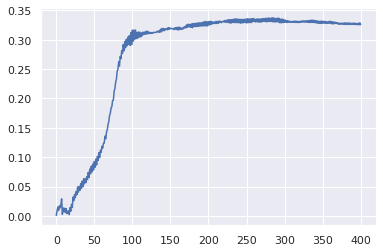

In [ ]:
plt.plot(overlap_list)


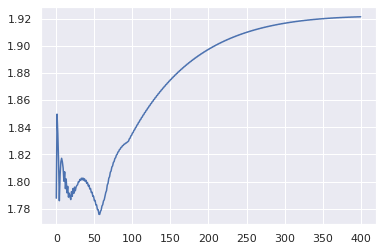

In [ ]:
plt.plot(delta_list)